# <center> Recommender systems </center>
## <center> 1$^{st}$ Assignment </center>
### <center> By Group 80 for the course Advances in Data Mining of the University of Leiden taught by Wojtek Kowalczyk </center>
<center> Lisa Dombrovskij (s1504819) - dombrovskij@strw.leidenuniv.nl </center>
<center> Margherita Grespan (s2233150) - grespan@strw.leidenuniv.nl </center>


In this work we study a typical *collaborative filtering problem*. Collaborative filtering is a technique used by recommender systems. 
In the past few decades this field of machine learning has been used for services like Netflix, Amazon, YouTube, and from  e-commerce to the ads on social media. The purpose of this technique is to make automatic predictions with known information about the taste of the user (previous ratings of movies, in this case). 
We will use a database containing movie ratings of a multitude of people and test different ways to implement a recommender system. The purpose is to implement different approaches using 5-fold cross-validation, understand how they work and pick the best combination of values to minimize the Root Mean Square Error (*RMSE*).

First, we implement 4 **naive approaches**, using four different parameters that all measure an aspect of the ratings in a unique way:
- **$R_{global}$** : Global average rating. The mean of all the ratings in the dataset.
- **$R_{item}$** : Average rating per item. The mean of all the ratings  given to a specific movie.
- **$R_{user}$** : Average rating per user. The mean of all the ratings given by a specific user.
- **$R_{user-item}$** : Linear combination of the previous two quantities.

Using $R_{global}$ is the simplest approach out of these four parameters. Because of this, we expect it to perform the worst. As $R_{user-item}$ incorporates both a measure of how well a movie does on average, as well as how the individual user rates movies, we expect it to perform better than the other three approaches. 

Besides these four *naive* approaches, a more sophisticated method will also be implemented. In this approach, named **matrix factorization**, the Gradient Descent algorithm is applied in order to minimize the error between the predicted and the true rating. These method has been proposed by [Takàcs et al. on 2007](https://www.cs.uic.edu/~liub/KDD-cup-2007/proceedings/gravity-Tikk.pdf/) and we will use their parameters configuration as starting point for our analysis.

## The dataset

This jupyter notebook uses the [1M movie ratings](https://grouplens.org/datasets/movielens/) dataset. 
We use files containing 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000. Each movie and user are unically identified by a *movie-ID* and *user-ID* respectively.  The data are contained in three tables with rating-, user- and movie statics:
- The **ratings** table contains information about the movies rating given by users: <UserID | MovieID | Rating | Timestamp>
- The **users** table encloses the information about the user who rated a movie like gender, age, occupation and zip code: <UserID |Gender | Age | Occupation | Zip-code>. 
- The **movies** table incorporates the name and genres of the movies: <MovieID | Title | Genres>

For this research, only the ratings table is relevant. 

## Method

First, all the relevant packages are imported for plotting, storing data and modelling. 

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.model_selection import KFold
np.warnings.filterwarnings('ignore')

### Preprocessing

Before we are able to implement the models, the data needs to be imported and preprocessed. The indices of the user-IDs and movie-IDs start at 1. Since it is custom to start counting from zero in Python, we subtract 1 from every index. This way, the indexing starts at 0. 

For a more robust model, 5-fold cross-validation is used. The data is randomly divided in 5 folds, or parts. The data is then trained on each combination of four trainingsets and a single testset, in such a way that each fold is used as a testset once. This method results in a model that is more generally applicable and avoids overfitting. 

In [4]:
#Read the data
movies_main = pd.read_csv('ml-1m/movies.dat', header=None, sep='::', names=['movie_ID','movie_name','movie_genre'])
users_main = pd.read_csv('ml-1m/users.dat', header=None, sep='::', names = ['user_ID','gender','age','occupation','zipcode'])
ratings_main = pd.read_csv('ml-1m/ratings.dat', header=None, sep='::', names = ['user_ID','movie_ID','rating','timestamp'])

#Shift all indices back by one so it starts at 0
users_main.user_ID = users_main.user_ID-1 
movies_main.movie_ID = movies_main.movie_ID-1
ratings_main.user_ID = ratings_main.user_ID-1
ratings_main.movie_ID = ratings_main.movie_ID-1

In [5]:
print('Amount of unique users in dataset: {}'.format(ratings_main.user_ID.nunique()))

Amount of unique users in dataset: 6040


In [6]:
def preprocess(X):
    
    '''
    Split the dataset into five folds. Every fold is used as a testset once.
    '''
    
    kf = KFold(n_splits=5, shuffle=True) #Define number of folds
    
    training_sets = []
    test_sets = []
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        training_sets.append(X_train)
        test_sets.append(X_test)

    return training_sets, test_sets

In [7]:
training_sets, test_sets = preprocess(ratings_main) #Split into five folds

# Global Average Rating - $R_{global}$

The first model that is used to predict the ratings for movies given by users, is based on the $R_{global}$ parameter. This parameter is defined as follows:

$R_{global} = \frac{1}{n} \sum_{i=1}^{i=n} rating_{i} $

With $rating_{i}$ the $i^{th}$ rating and n the total number of ratings in the dataset. This equation calculate the mean of all the ratings.  

In [8]:
def r_global(data):
    #Returns mean of all ratings
    return np.mean(data.rating.values)

In [9]:
print('Based on this dataset R_global = {}'.format(round(r_global(ratings_main), 2)))

Based on this dataset R_global = 3.58


For every fold, $R_{global}$ is calculated for the trainingset and this rating is used as the prediction for the training- and testset. For both the sets the RMSE (Root Mean Squared Error) is calculated, which is defined as

$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{i=n} (Y_{i} - \hat{Y}_{i})^2}$.

With n the total number of samples, $Y_{i}$ the true value of the $i^{th}$ sample and $\hat{Y}_{i}$ the prediction by the model of the $i^{th}$ sample.

In [10]:
rmse_trainsets = []
rmse_testsets = []

start_time = time.time()

for trainset, testset in zip(training_sets, test_sets):
    
        global_avg = r_global(trainset) #Take mean rating of all ratings in trainset, this is the prediction

        pred_train = [global_avg] * len(trainset)
        pred_test = [global_avg] * len(testset)

        rmse_trainsets.append(np.sqrt(mean_squared_error(trainset.rating.values, pred_train))) #Take error of prediction with true ratings
        rmse_testsets.append(np.sqrt(mean_squared_error(testset.rating.values, pred_test)))
        
elapsed_time = time.time() - start_time
print('Total time to run the model: {}'.format(elapsed_time))

Total time to run the model: 0.5275089740753174


The eventual root mean squared error of the trainingset for this model is the average of the root mean squared errors of the trainingset of every fold. The same is true for the root mean squared error of the testset. 

In [11]:
#print(mse_trainsets)
#print(mse_testsets)
print('Root Mean Squared Error Trainingset: {}'.format(round(np.mean(rmse_trainsets),2)))
print('Root Mean Squared Error Testset: {}.'.format(round(np.mean(rmse_testsets),2)))

Root Mean Squared Error Trainingset: 1.12
Root Mean Squared Error Testset: 1.12.


## Average Rating per item - $R_{item}$

The next model is based on the parameter $R_{item}$. The definition of this parameter for a specific movie is

$R_{item,movie_{ID}} = \frac{1}{k} \sum_{i=1}^{i=k} rating_{i}$.

With k the total number of ratings given to the specific movie and $rating_{i}$ the $i^{th}$ rating given to this movie.  This parameter calculates the average mean per movie. 

In [12]:
def r_item(movie_ID):
    #Returns the mean of all the ratings given to the specified movie
    return np.mean(ratings_main.loc[ratings_main.movie_ID == movie_ID].rating.values)

In [13]:
print('For example R_(item, 101) is {}'.format(round(r_item(101),2)))

For example R_(item, 101) is 1.82


This way, $R_{item}$ is calculated for every movie in the dataset and these values are put in a table.

In [14]:
#Create a dataframe with the R_item for every movie_ID
pred_frame_r_item = pd.DataFrame({'movie_ID': ratings_main.movie_ID.unique()})
pred_frame_r_item['r_item'] = pred_frame_r_item.apply(lambda x: r_item(x.movie_ID), axis=1)

In [15]:
pred_frame_r_item.head()

,movie_ID,r_item
0,1192,4.390725
1,660,3.464762
2,913,4.154088
3,3407,3.863878
4,2354,3.854375


The above is an example of the first five lines of the $R_{item}$ table.

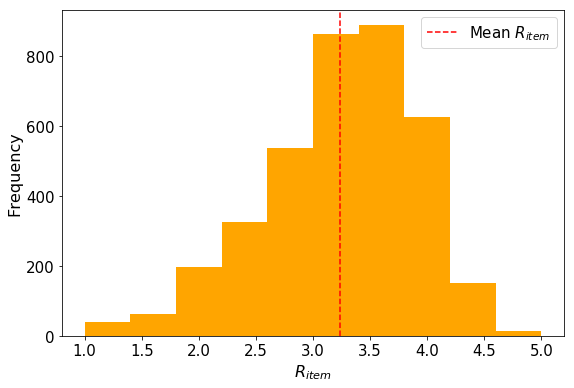

In [16]:
pred_frame_r_item.plot(y='r_item', kind='hist', color='orange',label = '_nolegend_', figsize=[9,6])
plt.axvline(x=pred_frame_r_item.r_item.mean(), color='red', ls='--',label='Mean $R_{item}$')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$R_{item}$',fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(fontsize=15);

In [17]:
print('Mean of all R_(item) values: {}'.format(round(pred_frame_r_item.r_item.mean(),2)))

Mean of all R_(item) values: 3.24


The figure above displays the distribution of $R_{item}$ for all the movies. The mean of the parameter is 3.24 and most movies have an average rating between 3 and 4.

The model is trained by looping over each fold and calculating the RMSE on the trainingset and testset by using the table of $R_{item}$ values as the prediction for the rating that the user will give to each movie. 

In [18]:
rmse_trainsets = []
rmse_testsets = []

start_time = time.time()

for trainset, testset in zip(training_sets, test_sets):
    
    #Add R_item of every movie to the movies in the trainingset
    temp_train = pd.merge(trainset, pred_frame_r_item, on='movie_ID', how='left') 
    pred_train = temp_train.r_item #This is the prediction
    
    #Add R_item of every movie to the movies in the testset
    temp_test = pd.merge(testset, pred_frame_r_item, on='movie_ID', how='left')
    pred_test = temp_test.r_item #this is the prediction

    rmse_trainsets.append(np.sqrt(mean_squared_error(trainset.rating.values, pred_train)))
    rmse_testsets.append(np.sqrt(mean_squared_error(testset.rating.values, pred_test)))
    
elapsed_time = time.time() - start_time
print('Total time to run the model: {}'.format(elapsed_time))

Total time to run the model: 1.0133848190307617


Again, the mean RMSE is taken over all the folds for the trainingset and testset respectively.

In [19]:
#print(rmse_trainsets)
#print(rmse_testsets)

print('Root Mean Squared Error Trainingset: {}'.format(round(np.mean(rmse_trainsets),2)))
print('Root Mean Squared Error Testset: {}.'.format(round(np.mean(rmse_testsets),2)))

Root Mean Squared Error Trainingset: 0.97
Root Mean Squared Error Testset: 0.97.


This model works better than the model using $R_{global}$, as the RMSE went down from 1.12 to 0.97.

## Average Rating per user - $R_{user}$

Another parameter that can be used as a model is $R_{user}$. This parameter is very similar to the $R_{item}$ parameter, but instead of taking the average over all ratings of a movie, the average of all ratings of a user is taken. This number gives the predicted rating for the next movie that the user will rate. The equation for $R_{user}$ for a specific user is

$R_{user,user_{ID}} = \frac{1}{p} \sum_{i=1}^{i=p} rating_{i}$.

With p the total number of movies rated by the specific user, and $rating_{i}$ the $i^{th}$ rating given by the user.

In [20]:
def r_user(user_ID):
    #Returns mean of all ratings given by the specified user
    return np.mean(ratings_main.loc[ratings_main.user_ID == user_ID].rating.values)

In [21]:
print('For example R_(user, 101) is {}'.format(round(r_user(101),2)))

For example R_(user, 101) is 3.13


In [22]:
#Create a dataframe with the R_user for every user_ID
pred_frame_r_user = pd.DataFrame({'user_ID': ratings_main.user_ID.unique()})
pred_frame_r_user['r_user'] = pred_frame_r_user.apply(lambda x: r_user(x.user_ID), axis=1)

In [23]:
pred_frame_r_user.head()

,user_ID,r_user
0,0,4.188679
1,1,3.713178
2,2,3.901961
3,3,4.190476
4,4,3.146465


Just as for $R_{item}$, a table is created with the $R_{user}$ value for every unique user-ID. These values are used as the prediction values for the model. The first five lines of this table can be seen above. 

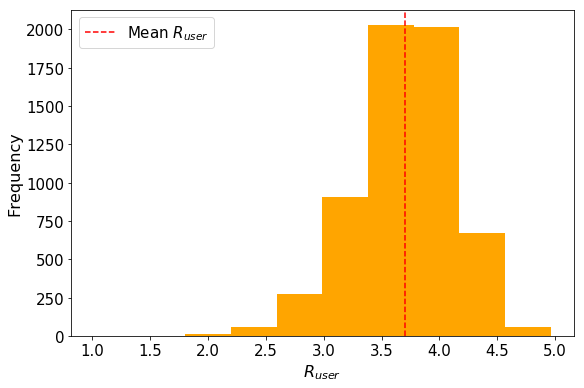

In [24]:
pred_frame_r_user.plot(y='r_user', kind='hist', color='orange',label = '_nolegend_', figsize=[9,6])
plt.axvline(x=pred_frame_r_user.r_user.mean(), color='red', ls='--',label='Mean $R_{user}$')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$R_{user}$',fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(fontsize=15);

In [25]:
print('Mean of all R_(user) values: {}'.format(round(pred_frame_r_user.r_user.mean(),2)))

Mean of all R_(user) values: 3.7


The figure above displays the distribution of $R_{user}$ for all users. The average $R_{user}$ is 3.7 and most of the $R_{user}$ values are distributed between 3 and 4, this means that most users rate their movies between 3 and 4 on average.

Below, the $R_{user}$ model is trained in the same way as the $R_{item}$ model; We loop over the five folds, predict each sample in the trainingset and testset using the $R_{user}$ prediction values and calculate the RMSE for both sets. Then, the average RMSE over all trainingsets and testsets, respectively, is taken to be the final trainerror and testerror of the model. 

In [26]:
rmse_trainsets = []
rmse_testsets = []


start_time = time.time()

for trainset, testset in zip(training_sets, test_sets):
    
    #Add R_user of every user to the users in the trainingset
    temp_train = pd.merge(trainset, pred_frame_r_user, on='user_ID', how='left')
    pred_train = temp_train.r_user

    #Add R_user of every user to the users in the testset
    temp_test = pd.merge(testset, pred_frame_r_user, on='user_ID', how='left')
    pred_test = temp_test.r_user

    rmse_trainsets.append(np.sqrt(mean_squared_error(trainset.rating.values, pred_train)))
    rmse_testsets.append(np.sqrt(mean_squared_error(testset.rating.values, pred_test)))
    
elapsed_time = time.time() - start_time
print('Total time to run the model: {}'.format(elapsed_time))

Total time to run the model: 0.7016680240631104


In [27]:
#rounded_trainset = [ '%.2f' % elem for elem in rmse_trainsets ]
#rounded_testset = [ '%.2f' % elem for elem in rmse_testsets ]
#print('Root Mean Squared Error Training Set for every fold:', rounded_trainset) ##why do we have folds here?
#print('Root Mean Squared Error Training Set for every fold:', rounded_testset)

print('Root Mean Squared Error Trainingset: {}'.format(round(np.mean(rmse_trainsets),2)))
print('Root Mean Squared Error Testset: {}.'.format(round(np.mean(rmse_testsets),2)))

Root Mean Squared Error Trainingset: 1.03
Root Mean Squared Error Testset: 1.03.


This model has a slightly higher error than the $R_{item}$ model (0.97), but has a lower error than the $R_{global}$ model (1.12).

## Linear Combination User Item - $R_{user,item}$

A reasonable first attempt at combing the $R_{user}$ and $R_{item}$ parameters is by using both of them in a single, linear model. This model will look as follows:

$y = \alpha \cdot x_{1} + \beta \cdot x_{2} + \gamma$

With $\alpha$, $\beta$ and $\gamma$ the constants that have to be optimized by the model, $x_{1}$ the $R_{user}$ values, $x_{2}$ the $R_{item}$ values and $y$ the rating given by the user to a particular movie. 

For a single fold, every $(R_{user}$,$R_{item})$ combination is a datapoint $(x_{1},x_{2})$ and the rating corresponding to this user/movie combination is the result of the linear equation. The linear model is fitted to the trainingset data. The best fitting constants are used to predict each datapoint in the train- and testset. 

In [28]:
def lin_eq(x1, x2, a, b, g):
    
    return a*x1+b*x2+g

The model is trained by looping over the folds. For each fold, the linear equation is fitted to the trainingset, using the least-squares method. This method minimizes the squared Euclidean 2-norm $\| b - a x \|^2_2$ for the equation $ax = b$.
This best fit is then used to predict the samples in testset. The RMSE is again calculated for the trainset and testset of every fold, and then the average is taken to obtain the average trainerror and testerror of the model.

In [29]:
rmse_trainsets = []
rmse_testsets = []


start_time = time.time()

for trainset, testset in zip(training_sets, test_sets):
    
    #Add r_user and r_item to every entry in the trainingset
    temp = pd.merge(trainset, pred_frame_r_user, on = 'user_ID', how='left')
    full_table_train = pd.merge(temp, pred_frame_r_item, on='movie_ID', how='left')
    
    #Add r_user and r_item to every entry in the testset
    temp1 = pd.merge(testset, pred_frame_r_user, on = 'user_ID', how='left')
    full_table_test = pd.merge(temp1, pred_frame_r_item, on='movie_ID', how='left')

    full_table_train['extra_col'] = 1 #Add extra column with a constant so the linear fit works
    
    input_data = full_table_train[['r_user','r_item','extra_col']]
    output_data = full_table_train[['rating']].values
    
    #Fit a linear model to the input and output data
    #The model is y = alpha * r_user + beta * r_item + gamma
    alpha, beta, gamma = np.linalg.lstsq(input_data, output_data)[0] 
    
    #Predict the trainingset with the linear model
    pred_train = lin_eq(full_table_train.r_user, full_table_train.r_item, alpha, beta, gamma)
    #Predict the testset with the linear model
    pred_test = lin_eq(full_table_test.r_user, full_table_test.r_item, alpha, beta, gamma)
    
    rmse_trainsets.append(np.sqrt(mean_squared_error(trainset.rating.values, pred_train)))
    rmse_testsets.append(np.sqrt(mean_squared_error(testset.rating.values, pred_test)))

elapsed_time = time.time() - start_time
print('Total time to run the model: {}'.format(elapsed_time))

Total time to run the model: 2.0535807609558105


In [30]:
#print(rmse_trainsets)
#print(rmse_testsets)

print('Root Mean Squared Error Trainingset: {}'.format(round(np.mean(rmse_trainsets),2)))
print('Root Mean Squared Error Testset: {}.'.format(round(np.mean(rmse_testsets),2)))

Root Mean Squared Error Trainingset: 0.92
Root Mean Squared Error Testset: 0.92.


### Overview of Results Naive Models


| Method      |  RMSE train |  RMSE test| Run time |
|-------------|-------|------|----------|
|   $R_{global}$  | 1.12  | 1.12 |  0.47s   |
|    $R_{item}$   | 0.97  | 0.97 |  0.86s   |
|    $R_{user}$   | 1.03  | 1.03 |  0.60s   |
| $R_{user-item}$ | 0.92  | 0.92 |  2.17s   |

The above table displays the results of the four naive approaches implemented as a recommender system for movie ratings by different users. The RMSE values are the averages taken over all folds after 5-fold cross-validation. The time it takes to run the model is also shown.

As we expected, the $R_{global}$ has the greatest error and $R_{user-item}$ the lowest. Notably, the errors of the trainset and testset do not differ for any of the methods when rounded to two decimals. 

## Matrix Factorization - Gradient Descent

Matrix factorization was first proposed by [Simon Funk](https://sifter.org/~simon/journal/20061211.html) in 2006.
This approach now is widely used in recommender systems. The concept behind it is to decompose a matrix, in this case the $R_{user-item}$ matrix, into the product of two lower dimension matrices. Essentially, it looks like

$R\approx U\cdot M\$,

with U and M weight matrices. U has a row for each user and M a column for each movie. The columns of U and rows of M stand for the features. So U will have a shape (number of users, number of features) and M will be (number of features, number of movies).

U and M are initialized with random values drawn from a Gaussian normal distribution: 

 $\mathcal{N}\left ( \sqrt{\frac{\overline{R_{fold,trainingset}}}{n}} , \frac{1}{n^{2}}\right )$,
 
 where $\overline{R_{fold,trainingset}}$ is the mean of the ratings of the trainingset in a fold and n the number of features. In order to find the best U and M values, i.e. minimize the error, we use the algorithm proposed by Takàcs et al. (2007). For every movie-user combination we compute the R matrix and subsequently the error. The error is simply the difference between the True ratings and the predicted ones:

$ e=True \, ratings - R $

Takàcs and his group propose to minimize the RMSE with the use of the Gradient Descent algorithm. This can be written as:

$u_{ik}^{'}=u_{ik}+\eta \cdot (2\cdot e_{ij}\cdot m_{kj}-\lambda \cdot u_{ik})$

$m_{kj}^{'}=m_{kj}+\eta \cdot (2\cdot e_{ij}\cdot u_{ik}-\lambda \cdot m_{kj})$

With $u_{ik}$ and $m_{kj}$ respectively the weight of the user and movie in the (i,k), (k,j) position and $e_{ij}$ the  error of the $i^{th}$ user $k^{th}$ movie combination. $\lambda$ is a small positive constant used as a regularization factor in order to avoid exploding weights and $\eta$ is the learning rate. 
Fundamentally, we predict the rating, compare it with the true value and adjust the weights in the opposite direction of the gradient.

The true-ratings matrix is a (6040, 3952) matrix, which contains the true rating for every user/movie combination by index. If the user did not rate the specific movie, the matrix contains a zero.

For every fold, new weight matrices U and M are initiated and trained using the above algorithm. After training for a set number of iterations, the final prediction for all user/movie combinations can be obtained by multiplying U and M and clipping the results between 1 and 5 (because there might be predictions below 1, which are set to 1 and predictions above 5, which are set to 5). This results in a prediction matrix with the same shape as the true-ratings matrix and corresponding indexing. The RMSE can then be calculated for the train samples and test samples, resulting in a trainset error and testset error for each fold. The average over the five folds is the final RMSE of the model.

In [31]:
temp = pd.merge(ratings_main, pred_frame_r_user, on = 'user_ID', how='left') #Merge the ratings with r_user and r_item values
full_table = pd.merge(temp, pred_frame_r_item, on='movie_ID', how='left')

In [32]:
#Create empty matrix to be filled with true ratings
true_ratings = np.zeros((np.max(full_table.user_ID.values)+1,np.max(full_table.movie_ID.values)+1))

In [33]:
true_ratings.shape #Check the shape

(6040, 3952)

In [34]:
#Fill the true ratings matrix with the true rating for every movie, nonexisting user/movie combinations remain having
#a value of zero.
for i, row in full_table.iterrows():
    true_ratings[int(row.user_ID), int(row.movie_ID)] = row.rating

In [35]:
#num_features=20 
num_features = 40
num_users = np.max(full_table.user_ID.values)+1
num_movies = np.max(full_table.movie_ID.values)+1

In [36]:
def create_weights(train_set):
    
    #Randomly intialized weights with a Gaussian normal distribution centered around the mean of the trainingset
    
    mu = np.sqrt(np.mean(train_set.rating.values)/num_features)
    std = np.std(train_set.rating.values)/num_features
    U = np.random.normal(loc=mu, scale=std, size=(num_users, num_features))
    M = np.random.normal(loc=mu, scale=std, size=(num_features, num_movies))
    
    return U, M

In [ ]:
#Define the parameters
counter = 0 
num_it = 50
l_rate = 0.007
lambda_reg = 0.020
count_time=[]

#Intiate empty matrices to store RMSE values for all iterations
RMSE_matrix_train = np.zeros((len(training_sets), num_it))
RMSE_matrix_test = np.zeros((len(test_sets), num_it))


#Loop over every fold
for k, (trainset, testset) in enumerate(zip(training_sets, test_sets)):
    print('Fold: {}'.format(k))
    
    start_time = time.time()
    
    #Initiate weight matrices
    U, M = create_weights(trainset)
    
    #Loop over number of iterations
    for n in range(num_it):
        
        print('Iteration: {}/{}'.format(n, num_it))
        #Loop over every user/movie combination in the trainingset of the fold
        for i, (m_ID, u_ID) in enumerate(zip(trainset.movie_ID.values, trainset.user_ID.values)):

            if counter % 100000 == 0:
                print(counter)
            
            #Get the current prediction of this user/movie combination
            pred = np.dot(U[int(u_ID),:],M[:,int(m_ID)])
            err = true_ratings[int(u_ID), int(m_ID)] - pred #Error of the prediction

            #Update the U and M matrices based on the error
            U[int(u_ID),:] = U[int(u_ID),:]+l_rate*(2*err*M[:,int(m_ID)]-lambda_reg*U[int(u_ID),:])
            M[:,int(m_ID)] = M[:,int(m_ID)]+l_rate*(2*err*U[int(u_ID),:]-lambda_reg*M[:,int(m_ID)])

            #Build in check to see if there are no exploding weights
            if (np.isnan(U[int(u_ID),:]) == True).any():
                print(U[int(u_ID),:])

            counter+=1
        
        #Final prediction of the fold after training and clipping it between 1 and 5
        final_pred_fold = np.clip(np.matmul(U,M), 1,5)
        
        train_set_true = true_ratings[trainset.user_ID.values, trainset.movie_ID.values]#True ratings of trainset
        train_set_predictions = final_pred_fold[trainset.user_ID.values, trainset.movie_ID.values] #predicted ratings of trainset
        RMSE_matrix_train[k,n] = np.sqrt(mean_squared_error(train_set_true, train_set_predictions)) #RMSE trainset
        
        test_set_true = true_ratings[testset.user_ID.values, testset.movie_ID.values] #True ratings of testset
        test_set_predictions = final_pred_fold[testset.user_ID.values, testset.movie_ID.values] #Predicted ratings of testset
        RMSE_matrix_test[k,n] = np.sqrt(mean_squared_error(test_set_true, test_set_predictions)) #RMSE testset
        
    elapsed_time = time.time() - start_time
    count_time.append(elapsed_time)

In [ ]:
#save the RMSE matrix
with open('RMSE_matrix_train'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'wb') as handle:
    pickle.dump(RMSE_matrix_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('RMSE_matrix_test'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'wb') as handle:
    pickle.dump(RMSE_matrix_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
#save U matrix
with open('U_iter_'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'wb') as handle:
    pickle.dump(U, handle, protocol=pickle.HIGHEST_PROTOCOL)
#save M matrix 
with open('M_iter_'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'wb') as handle:
    pickle.dump(M, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('Time_iter_'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'wb') as handle:
    pickle.dump(count_time, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Results Gradient Descent Matrix Factorization

The model that is used is based on the model used by the Takàcs et al. paper published in 2007. Following the method of Takàcs et al., we take the combination of the learning rate, regularization parameter and number of features that produced the lowest error for their dataset and see how it works on this dataset. The parameters used are:


| $\lambda$ | $\eta$ | num. features |
|-----------|--------|--------------------|
| 0.02      | 0.005  | 40

On the Netflix dataset used by Takàcs et al., this combination of parameters gives a RMSE of 0.9190. We now apply this method to the MovieLens dataset.

In [42]:
num_it_read = 50
lambda_reg_read = 0.02
l_rate_read = 0.005
num_feat = 40 #20, 10

In [43]:
def read_files(num_it,lambda_reg,l_rate,num_features):
    #upload pickle files
    with open('RMSE_matrix_train'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'rb') as handle:
        RMSE_matrix_train = pickle.load(handle)

    with open('RMSE_matrix_test'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'rb') as handle:
        RMSE_matrix_test = pickle.load(handle)

    with open('U_iter_'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'rb') as handle:
        U = pickle.load(handle)

    with open('M_iter_'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'rb') as handle:
        M = pickle.load(handle)

    with open('Time_iter_'+str(num_it)+'lambda_'+str(lambda_reg)+'l_rate_'+str(l_rate)+'_features_'+str(num_features)+'.pickle', 'rb') as handle:
        T = pickle.load(handle)
   
    return RMSE_matrix_train, RMSE_matrix_test, U, M, T 

In [44]:
def final_error(RMSE_matrix): #the final error is the mean of the folds' errors
    eventual_errors = [RMSE_matrix[x][-1] for x in range(5)]
    rsme_gd = np.mean(eventual_errors)
    return rsme_gd

In [45]:
def plot_mean_RSME(RSME_train, RSME_test): #plot the error against the number of iterations
    
    means_iter_train = [np.mean(RSME_train[:,x]) for x in range(len(RSME_train[0]))]
    means_iter_test = [np.mean(RSME_test[:,x]) for x in range(len(RSME_test[0]))]
    
    
    plt.figure(figsize=[14,8])
    plt.plot(means_iter_train, lw=2, label='Trainset')
    plt.plot(means_iter_test, lw=2, label='Testset')
    
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Root Mean Squared Error', fontsize=18)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    
    plt.title('Regulation Parameter: {}, Learning Rate: {}, Number of Features: {}'.format(lambda_reg_read,l_rate_read,num_feat), fontsize=16)

Total time to run the model: 15951.8 s


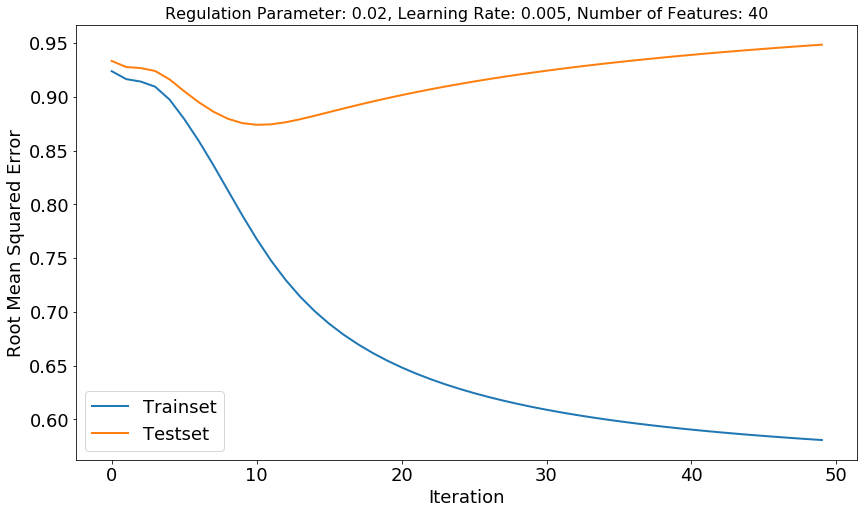

In [54]:
RMSE_matrix_train, RMSE_matrix_test, U, M, T = read_files(num_it_read,lambda_reg_read,l_rate_read,num_feat)
plot_mean_RSME(RMSE_matrix_train,RMSE_matrix_test)

print('Total time to run the model:',round(np.sum(T),1),'s')

The above figure displays the results of the combinations of parameters mentioned above. This combination produced the lowest error on the Netflix dataset used by Takàcs et al. It is clear that the matrix factorization method works for the purpose of reducing the trainingset error. However, the testset error, after decreasing for a few iterations, keeps increasing. This is a clear sign of overfitting. The model adapts well to the trainingdata, but specializes to such an extend, that it is not generally applicable to data it has not seen yet (the testset). Considering the fact that the Netflix data used by Takàcs et al. is much larger than the dataset from MovieLens used in this notebook 100 million vs. 1 million samples), the number of features might be the cause of the overfitting. There could be too many features for the complexity of the data. To test this hypothesis, the model is trained again, with the same learning rate and regularization parameter, but now with 20 features instead of 40. 

Total time to run the model: 7128.4 s


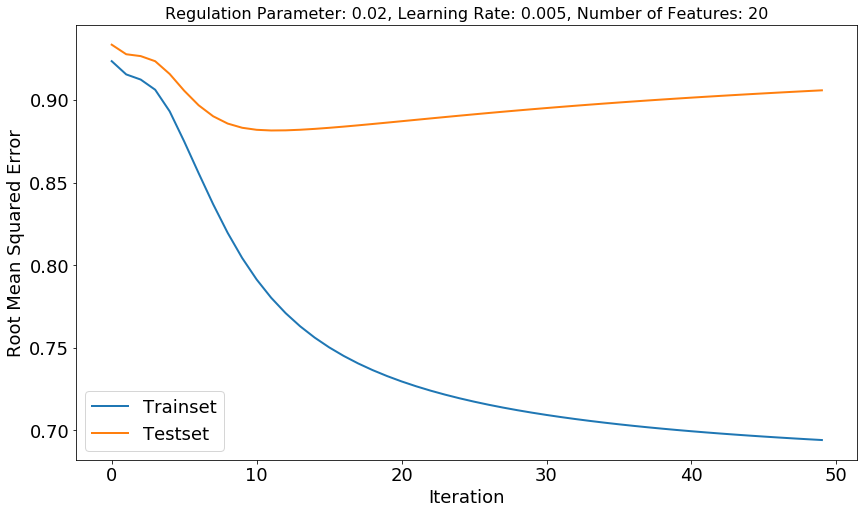

In [55]:
num_feat=20
RMSE_matrix_train, RMSE_matrix_test, U, M, T = read_files(num_it_read,lambda_reg_read,l_rate_read,num_feat)
plot_mean_RSME(RMSE_matrix_train,RMSE_matrix_test)
print('Total time to run the model:',round(np.sum(T),1),'s')

The overfitting is clearly happening to a lesser extent with 20 features than with 40 features, but it is still evident in the figure shown above. We run the model again, but this time with 10 features.

Total time to run the model: 7259.8 s


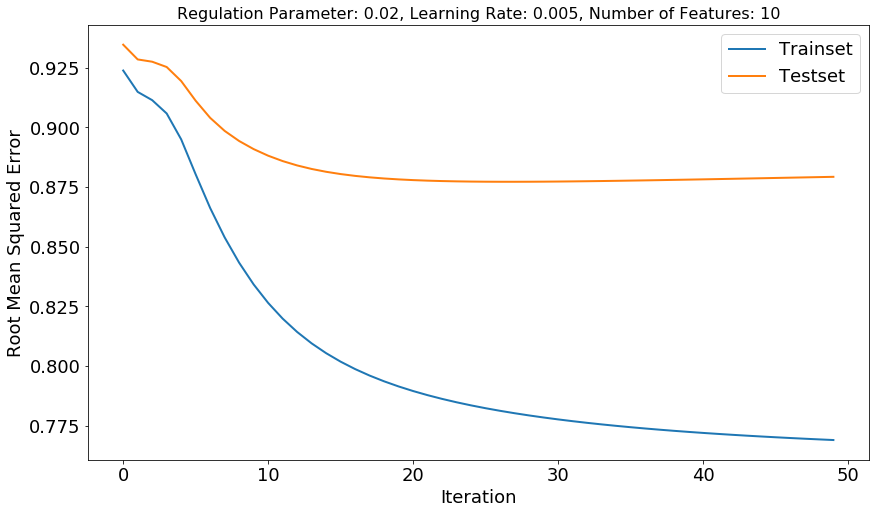

In [56]:
num_feat=10
RMSE_matrix_train, RMSE_matrix_test, U, M, T = read_files(num_it_read,lambda_reg_read,l_rate_read,num_feat)
plot_mean_RSME(RMSE_matrix_train,RMSE_matrix_test)
print('Total time to run the model:',round(np.sum(T),1),'s')

This model works much better and the overfitting is clearly reduced when compared to the model with 40 features. This goes to show that the learning rate and regularization parameter values that worked for the dataset Takàcs et al. used, also seem to work well for this dataset, but the number of features needs to be reduced in order to adapt to the smaller size of the dataset. 

The eventual RMSE of this model is 0.7690 for the trainingset, and 0.8793 for the testset.

All of the errors can be seen in the table below. Every model ran for 50 iterations over all samples.

 | num. features | RMSE train | RMSE test | Run time (s) |
|---------------|------------|-----------|--------------|
| 40            | 0.5809     | 0.9485    | 15951.8     |
| 20            | 0.6942     | 0.9059    | 7128.4      |
| 10            | 0.7690     | 0.8793    | 7259.8     |


The model that works best is the model with 10 features, which has a RMSE of 0.88 on the testset. This is smaller than the errors for the naive methods. The naive method that works the best is the linear combination model. This model has a RMSE of 0.92 on both the trainset and the testset. 

The table above displays the interesting effect of overfitting, and emphasizes the importance of splitting a dataset into a trainset and a testset. Even though the error on the trainset increases as the number of features decreases, the error on the testset decreases. This is because the model with 40 features, where the overfitting happens the most, the model adapts very well to the train data, but not to the test data. Even though the error on the trainset is worse for the model with 10 features, the model is more generally applicable, and works better on data it has not seen yet. 

### An Aside: Rounding the Predictions

One notable aspect of this recommendation system, is that the users are only able to give a rating of 1, 2, 3, 4 or 5, i.e. integers. In the models above, we have assumed that ratings that are not integers are also possible and the errors have been calculated based on predictions that are often non-integer numbers. In reality, if one wants to use this model as a true predictor of what rating the user would give to a movie, the prediction needs to be rounded to the closest integer. This will most likely result in a different RMSE. As such, that error value is arguably a more realistic reflection of how well the model works to predict user ratings. 